# Metadata + CLIP Visual Agreement Groups

Find groups where both conditions hold:
1. **Metadata Agreement (Hard)**: Samples with identical ecological metadata (habitat, substrate, location, date)
2. **CLIP Visual Agreement (Threshold)**: High visual similarity using CLIP features (≥ threshold)

**Goal**: Identify and visualize strong multimodal agreement groups.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import clip
import torch
import faiss
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Paths
metadata_path = '/work3/monka/SummerSchool2025/metadata.csv'
image_path = '/work3/monka/SummerSchool2025/FungiImages/'

# Load metadata
df = pd.read_csv(metadata_path)
testset_df = df[df['filename_index'].str.contains('test|final')].copy()
print(f"Total testset samples: {len(testset_df):,}")

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print(f"Using device: {device}")

/work3/monka/SummerSchool2025/MultimodalDataChallenge2025/.venv/lib64/python3.9/site-packages/clip/clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging


Total testset samples: 10,152
Using device: cuda
Using device: cuda


In [2]:
# Step 1: Create metadata signatures (hard grouping)
def create_metadata_signature(row):
    """Create identical metadata signature for hard grouping"""
    habitat = str(row['Habitat']) if pd.notna(row['Habitat']) else 'Unknown'
    substrate = str(row['Substrate']) if pd.notna(row['Substrate']) else 'Unknown'
    
    # Round coordinates for location grouping
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        lat = round(float(row['Latitude']), 3)
        lon = round(float(row['Longitude']), 3)
        location = f"Lat_{lat}_Lon_{lon}"
    else:
        location = "Unknown"
    
    # Year-month for temporal grouping
    if pd.notna(row['eventDate']):
        try:
            date_obj = pd.to_datetime(row['eventDate'])
            date = f"{date_obj.year}-{date_obj.month:02d}"
        except:
            date = "Unknown"
    else:
        date = "Unknown"
    
    return f"{habitat}|{substrate}|{location}|{date}"

# Create metadata groups
testset_df['metadata_signature'] = testset_df.apply(create_metadata_signature, axis=1)
metadata_groups = defaultdict(list)

for _, row in testset_df.iterrows():
    metadata_groups[row['metadata_signature']].append(row['filename_index'])

# Filter groups with multiple samples
multi_sample_groups = {k: v for k, v in metadata_groups.items() if len(v) >= 2}
print(f"Metadata groups with 2+ samples: {len(multi_sample_groups)}")
print(f"Total samples in these groups: {sum(len(v) for v in multi_sample_groups.values())}")

Metadata groups with 2+ samples: 1648
Total samples in these groups: 3858


In [3]:
# Step 2: Extract CLIP features for visual similarity
def extract_clip_features(filenames, batch_size=32):
    """Extract CLIP features for given filenames"""
    features = []
    valid_filenames = []
    
    for i in tqdm(range(0, len(filenames), batch_size), desc="Extracting CLIP features"):
        batch_files = filenames[i:i+batch_size]
        batch_images = []
        batch_names = []
        
        for filename in batch_files:
            img_path = os.path.join(image_path, filename)
            if os.path.exists(img_path):
                try:
                    with Image.open(img_path) as img:
                        img_tensor = preprocess(img.convert('RGB')).unsqueeze(0)
                        batch_images.append(img_tensor)
                        batch_names.append(filename)
                except:
                    continue
        
        if batch_images:
            batch_tensor = torch.cat(batch_images, dim=0).to(device)
            with torch.no_grad():
                batch_features = model.encode_image(batch_tensor).cpu().numpy()
            features.extend(batch_features)
            valid_filenames.extend(batch_names)
    
    return np.array(features), valid_filenames

# Get all filenames from metadata groups
all_filenames = []
for filenames in multi_sample_groups.values():
    all_filenames.extend(filenames)
all_filenames = list(set(all_filenames))

# Extract CLIP features
clip_features, valid_filenames = extract_clip_features(all_filenames)
clip_features = clip_features / np.linalg.norm(clip_features, axis=1, keepdims=True)  # Normalize

print(f"Extracted CLIP features for {len(valid_filenames)} images")

# Create filename to feature index mapping
filename_to_idx = {name: i for i, name in enumerate(valid_filenames)}

Extracting CLIP features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [01:31<00:00,  1.32it/s]

Extracted CLIP features for 3858 images


In [4]:
# Step 3: Find groups with both metadata AND visual agreement
def find_visual_subgroups(filenames, threshold=0.9):
    """
    Split a metadata group into visual subgroups based on pairwise similarity threshold.
    """
    valid_files = [f for f in filenames if f in filename_to_idx]
    
    if len(valid_files) < 2:
        return []
    
    n = len(valid_files)
    
    # Create similarity matrix
    similarity_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                similarity_matrix[i][j] = 1.0
            else:
                idx1 = filename_to_idx[valid_files[i]]
                idx2 = filename_to_idx[valid_files[j]]
                sim = np.dot(clip_features[idx1], clip_features[idx2])
                similarity_matrix[i][j] = sim
    
    # Find all pairs with similarity > threshold
    high_sim_pairs = []
    for i in range(n):
        for j in range(i+1, n):
            if similarity_matrix[i][j] > threshold:
                high_sim_pairs.append((i, j))
    
    # If no high similarity pairs, return empty
    if not high_sim_pairs:
        return []
    
    # Get all elements that participate in high similarity pairs
    participating_elements = set()
    for i, j in high_sim_pairs:
        participating_elements.add(i)
        participating_elements.add(j)
    
    # Create one subgroup with all participating elements
    if len(participating_elements) >= 2:
        subgroup_files = [valid_files[idx] for idx in participating_elements]
        
        # Calculate average similarity for this subgroup
        similarities = []
        for i in participating_elements:
            for j in participating_elements:
                if i < j:
                    similarities.append(similarity_matrix[i][j])
        
        return [{
            'filenames': subgroup_files,
            'count': len(subgroup_files),
            'avg_visual_similarity': np.mean(similarities),
            'num_pairs': len(similarities)
        }]
    
    return []

# Find agreement groups
visual_threshold = 0.9
agreement_groups = {}

print(f"Finding visual subgroups with pairwise similarity > {visual_threshold}...")

for signature, filenames in tqdm(multi_sample_groups.items()):
    # Find visual subgroups within this metadata group
    visual_subgroups = find_visual_subgroups(filenames, visual_threshold)
    
    # Add each visual subgroup as a separate agreement group
    for i, subgroup in enumerate(visual_subgroups):
        if subgroup['avg_visual_similarity'] < visual_threshold:
            continue
        
        parts = signature.split('|')
        group_key = f"{signature}_subgroup_{i}" if len(visual_subgroups) > 1 else signature
        
        agreement_groups[group_key] = {
            'filenames': subgroup['filenames'],
            'count': subgroup['count'],
            'avg_visual_similarity': subgroup['avg_visual_similarity'],
            'num_pairs': subgroup['num_pairs'],
            'habitat': parts[0] if len(parts) > 0 else 'Unknown',
            'substrate': parts[1] if len(parts) > 1 else 'Unknown',
            'location': parts[2] if len(parts) > 2 else 'Unknown',
            'date': parts[3] if len(parts) > 3 else 'Unknown'
        }

print(f"Found {len(agreement_groups)} groups with both metadata AND visual agreement!")
print(f"Total samples in agreement groups: {sum(g['count'] for g in agreement_groups.values())}")

# Sort by visual similarity
sorted_groups = sorted(agreement_groups.items(), key=lambda x: x[1]['avg_visual_similarity'], reverse=True)

Finding visual subgroups with pairwise similarity > 0.9...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648/1648 [00:00<00:00, 53532.42it/s]

Found 671 groups with both metadata AND visual agreement!
Total samples in agreement groups: 1458


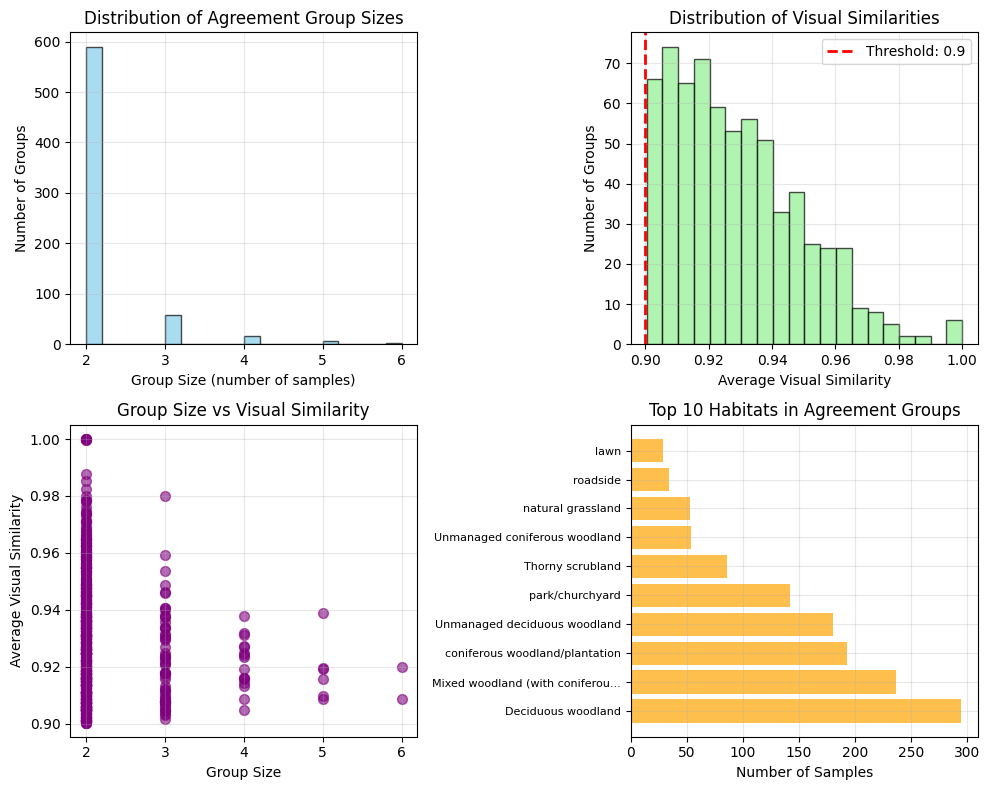


Agreement Groups Statistics:
- Total groups: 671
- Average group size: 2.2
- Largest group: 6 samples
- Average visual similarity: 0.929
- Highest similarity: 1.000


In [5]:
# Step 4: Plot statistics about agreement groups
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Reduced from (15, 10)

# 1. Distribution of group sizes
group_sizes = [g['count'] for g in agreement_groups.values()]
axes[0,0].hist(group_sizes, bins=20, color='skyblue', alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Group Size (number of samples)')
axes[0,0].set_ylabel('Number of Groups')
axes[0,0].set_title('Distribution of Agreement Group Sizes')
axes[0,0].grid(True, alpha=0.3)

# 2. Distribution of visual similarities
similarities = [g['avg_visual_similarity'] for g in agreement_groups.values()]
axes[0,1].hist(similarities, bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
axes[0,1].axvline(visual_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {visual_threshold}')
axes[0,1].set_xlabel('Average Visual Similarity')
axes[0,1].set_ylabel('Number of Groups')
axes[0,1].set_title('Distribution of Visual Similarities')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Group size vs visual similarity
axes[1,0].scatter(group_sizes, similarities, alpha=0.6, color='purple', s=50)
axes[1,0].set_xlabel('Group Size')
axes[1,0].set_ylabel('Average Visual Similarity')
axes[1,0].set_title('Group Size vs Visual Similarity')
axes[1,0].grid(True, alpha=0.3)

# 4. Top habitats in agreement groups
habitat_counts = defaultdict(int)
for group in agreement_groups.values():
    habitat_counts[group['habitat']] += group['count']

top_habitats = sorted(habitat_counts.items(), key=lambda x: x[1], reverse=True)[:10]
if top_habitats:
    habitats, counts = zip(*top_habitats)
    axes[1,1].barh(range(len(habitats)), counts, color='orange', alpha=0.7)
    axes[1,1].set_yticks(range(len(habitats)))
    axes[1,1].set_yticklabels([h[:30] + '...' if len(h) > 30 else h for h in habitats], fontsize=8)
    axes[1,1].set_xlabel('Number of Samples')
    axes[1,1].set_title('Top 10 Habitats in Agreement Groups')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAgreement Groups Statistics:")
print(f"- Total groups: {len(agreement_groups)}")
if group_sizes:  # Check if list is not empty
    print(f"- Average group size: {np.mean(group_sizes):.1f}")
    print(f"- Largest group: {max(group_sizes)} samples")
if similarities:  # Check if list is not empty
    print(f"- Average visual similarity: {np.mean(similarities):.3f}")
    print(f"- Highest similarity: {max(similarities):.3f}")

In [6]:
# Step 5: Visualize samples from top 10 agreement groups
def visualize_agreement_group(group_info, group_idx, max_images=6):
    """Visualize samples from an agreement group"""
    filenames = group_info['filenames']
    
    # Sample images if group is large
    display_files = filenames[:max_images] if len(filenames) <= max_images else np.random.choice(filenames, max_images, replace=False)
    
    # Create subplot with smaller, fixed size
    cols = min(3, len(display_files))
    rows = (len(display_files) + cols - 1) // cols
    # Cap the figure size to prevent excessive memory usage
    max_height = min(8, 2 * rows)  # Maximum height of 8 inches
    fig, axes = plt.subplots(rows, cols, figsize=(9, max_height))  # Reduced and capped size
    
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    for i, filename in enumerate(display_files):
        if i >= len(axes):
            break
            
        img_path = os.path.join(image_path, filename)
        if os.path.exists(img_path):
            try:
                with Image.open(img_path) as img:
                    # Resize image to reduce memory usage
                    img_resized = img.convert('RGB').resize((200, 200), Image.Resampling.LANCZOS)
                    axes[i].imshow(img_resized)
                    axes[i].set_title(filename, fontsize=8)
                    axes[i].axis('off')
            except:
                axes[i].text(0.5, 0.5, f"Error: {filename}", ha='center', va='center')
                axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f"Missing: {filename}", ha='center', va='center')
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(display_files), len(axes)):
        axes[i].axis('off')
    
    # Add group information
    title = f"Group {group_idx}: {group_info['count']} samples, Similarity: {group_info['avg_visual_similarity']:.3f}\n"
    title += f"Habitat: {group_info['habitat']}, Substrate: {group_info['substrate']}"
    plt.suptitle(title, fontsize=10, fontweight='bold')  # Reduced font size
    plt.tight_layout()
    plt.show()
    plt.close()  # Explicitly close figure to free memory

Visualizing top 25 agreement groups (lowest visual similarity)...

Group 1:
  Visual Similarity: 0.902
  Sample Count: 2
  Habitat: hedgerow
  Substrate: soil
  Location: Lat_55.002_Lon_15.073
  Date: 2020-09
  Files: fungi_final001820.jpg, fungi_test002807.jpg...


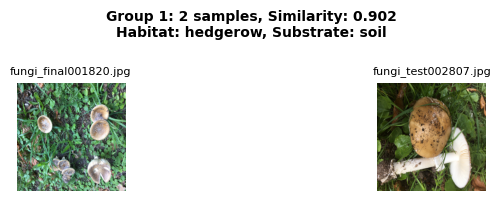


Group 2:
  Visual Similarity: 0.902
  Sample Count: 2
  Habitat: Unmanaged deciduous woodland
  Substrate: soil
  Location: Lat_56.298_Lon_10.321
  Date: 2017-09
  Files: fungi_final003425.jpg, fungi_test003578.jpg...


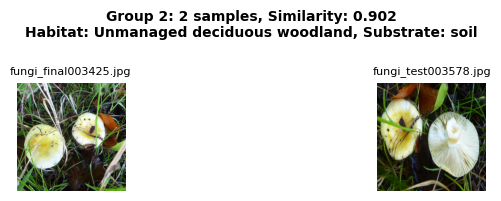


Group 3:
  Visual Similarity: 0.902
  Sample Count: 2
  Habitat: coniferous woodland/plantation
  Substrate: leaf or needle litter
  Location: Lat_57.071_Lon_8.629
  Date: 2013-10
  Files: fungi_final000245.jpg, fungi_test001895.jpg...


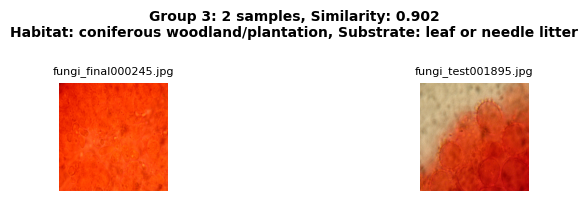


Group 4:
  Visual Similarity: 0.902
  Sample Count: 2
  Habitat: Unmanaged deciduous woodland
  Substrate: dead wood (including bark)
  Location: Lat_56.635_Lon_9.808
  Date: 2019-06
  Files: fungi_final000384.jpg, fungi_final001675.jpg...


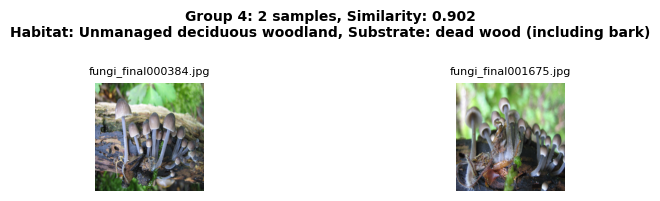


Group 5:
  Visual Similarity: 0.902
  Sample Count: 2
  Habitat: Unmanaged deciduous woodland
  Substrate: dead wood (including bark)
  Location: Lat_55.379_Lon_10.427
  Date: 2019-10
  Files: fungi_final001112.jpg, fungi_test002428.jpg...


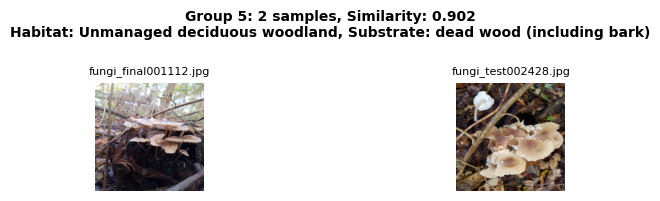


Group 6:
  Visual Similarity: 0.902
  Sample Count: 2
  Habitat: Mixed woodland (with coniferous and deciduous trees)
  Substrate: soil
  Location: Lat_55.954_Lon_11.74
  Date: 2018-10
  Files: fungi_test000842.jpg, fungi_test004293.jpg...


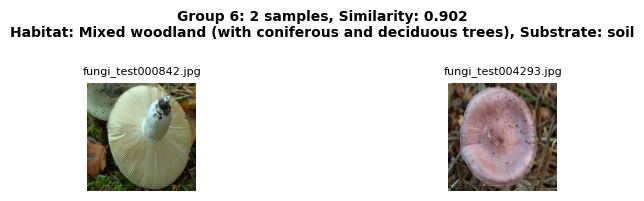


Group 7:
  Visual Similarity: 0.902
  Sample Count: 2
  Habitat: Deciduous woodland
  Substrate: dead wood (including bark)
  Location: Lat_55.812_Lon_12.487
  Date: 2018-11
  Files: fungi_test001125.jpg, fungi_test003105.jpg...


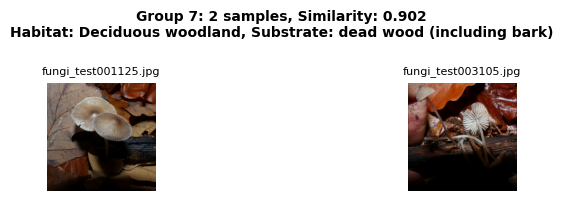


Group 8:
  Visual Similarity: 0.902
  Sample Count: 3
  Habitat: Unmanaged deciduous woodland
  Substrate: dead wood (including bark)
  Location: Lat_55.385_Lon_10.342
  Date: 2020-09
  Files: fungi_final000872.jpg, fungi_final001997.jpg, fungi_test004127.jpg...


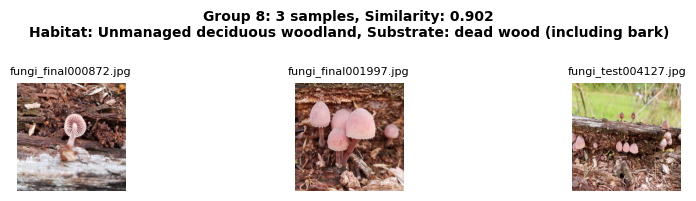


Group 9:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: Mixed woodland (with coniferous and deciduous trees)
  Substrate: soil
  Location: Lat_55.648_Lon_8.506
  Date: 2019-08
  Files: fungi_final001096.jpg, fungi_test004020.jpg...


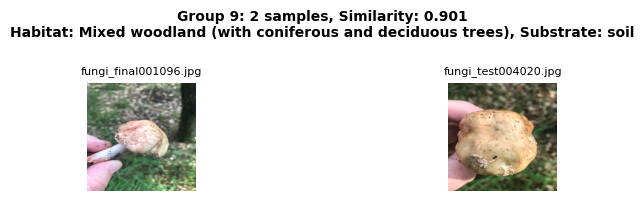


Group 10:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: lawn
  Substrate: stems of herbs, grass etc
  Location: Lat_55.949_Lon_10.448
  Date: 2011-07
  Files: fungi_final000770.jpg, fungi_test001441.jpg...


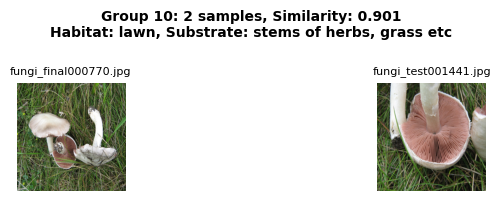


Group 11:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: Deciduous woodland
  Substrate: soil
  Location: Lat_54.973_Lon_12.081
  Date: 2017-08
  Files: fungi_test000492.jpg, fungi_test003401.jpg...


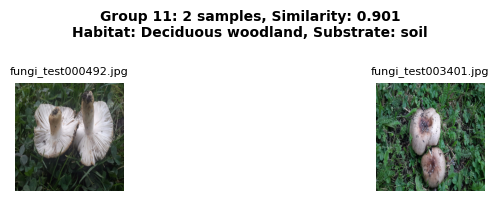


Group 12:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: Deciduous woodland
  Substrate: wood
  Location: Lat_55.78_Lon_12.497
  Date: 2016-09
  Files: fungi_test000650.jpg, fungi_test001156.jpg...


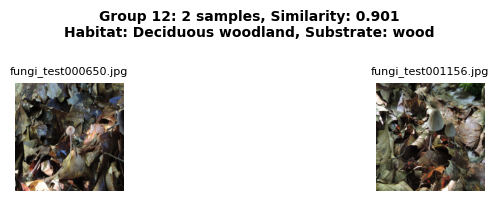


Group 13:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: Mixed woodland (with coniferous and deciduous trees)
  Substrate: soil
  Location: Lat_55.851_Lon_12.361
  Date: 2018-11
  Files: fungi_test000793.jpg, fungi_test006335.jpg...


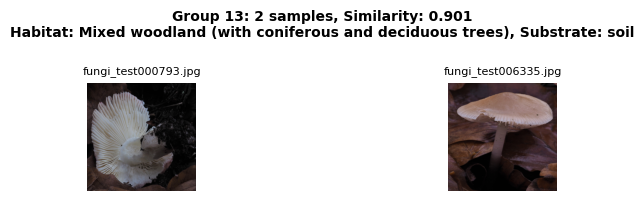


Group 14:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: coniferous woodland/plantation
  Substrate: soil
  Location: Lat_55.271_Lon_8.954
  Date: 2020-07
  Files: fungi_final000747.jpg, fungi_test005591.jpg...


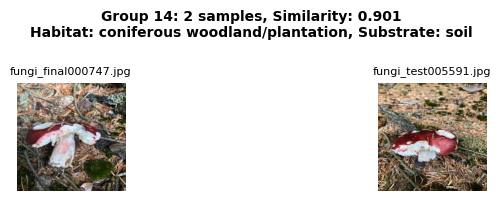


Group 15:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: coniferous woodland/plantation
  Substrate: soil
  Location: Lat_56.499_Lon_8.344
  Date: 2019-10
  Files: fungi_final000760.jpg, fungi_test003760.jpg...


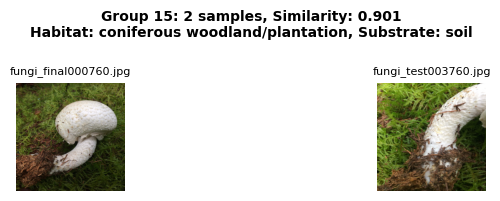


Group 16:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: Unmanaged deciduous woodland
  Substrate: soil
  Location: Lat_56.636_Lon_9.842
  Date: 2017-09
  Files: fungi_final001146.jpg, fungi_test002750.jpg...


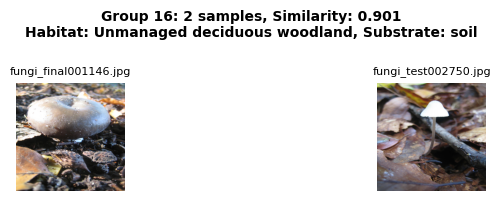


Group 17:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: Deciduous woodland
  Substrate: soil
  Location: Lat_55.228_Lon_12.214
  Date: 2016-08
  Files: fungi_final002931.jpg, fungi_test004845.jpg...


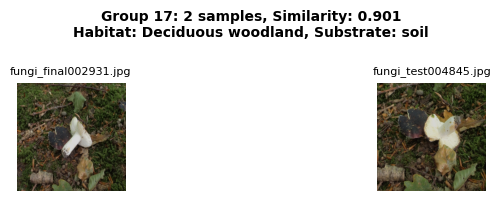


Group 18:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: Deciduous woodland
  Substrate: soil
  Location: Lat_55.819_Lon_12.503
  Date: 2019-10
  Files: fungi_final002995.jpg, fungi_test000076.jpg...


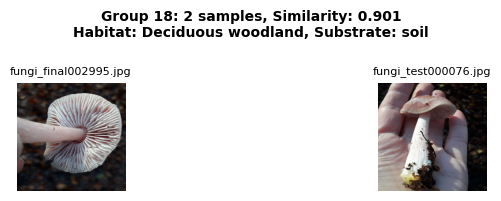


Group 19:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: Deciduous woodland
  Substrate: dead wood (including bark)
  Location: Lat_55.771_Lon_12.402
  Date: 2020-09
  Files: fungi_final003448.jpg, fungi_test004871.jpg...


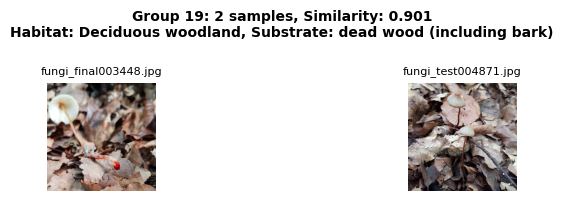


Group 20:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: coniferous woodland/plantation
  Substrate: soil
  Location: Lat_55.908_Lon_12.358
  Date: 2010-11
  Files: fungi_final003481.jpg, fungi_test002128.jpg...


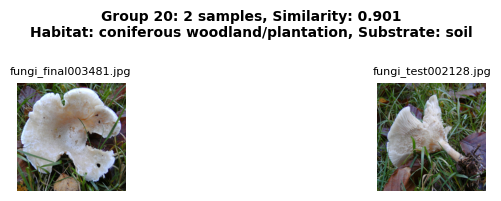


Group 21:
  Visual Similarity: 0.901
  Sample Count: 2
  Habitat: lawn
  Substrate: soil
  Location: Lat_56.077_Lon_12.544
  Date: 2018-11
  Files: fungi_test002111.jpg, fungi_test005028.jpg...


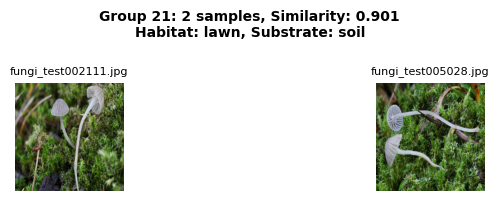


Group 22:
  Visual Similarity: 0.900
  Sample Count: 2
  Habitat: Unmanaged coniferous woodland
  Substrate: soil
  Location: Lat_55.018_Lon_15.115
  Date: 2019-08
  Files: fungi_final001147.jpg, fungi_final001933.jpg...


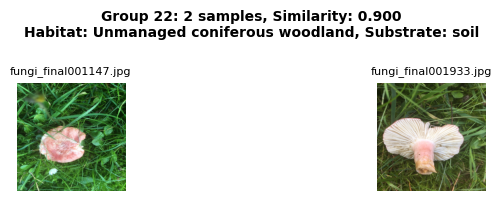


Group 23:
  Visual Similarity: 0.900
  Sample Count: 2
  Habitat: Unmanaged deciduous woodland
  Substrate: dead wood (including bark)
  Location: Lat_56.639_Lon_9.82
  Date: 2017-09
  Files: fungi_final003028.jpg, fungi_test005942.jpg...


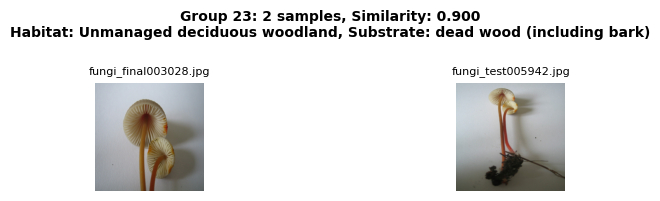


Group 24:
  Visual Similarity: 0.900
  Sample Count: 2
  Habitat: Unmanaged deciduous woodland
  Substrate: soil
  Location: Lat_56.075_Lon_10.253
  Date: 2018-08
  Files: fungi_test001323.jpg, fungi_test005754.jpg...


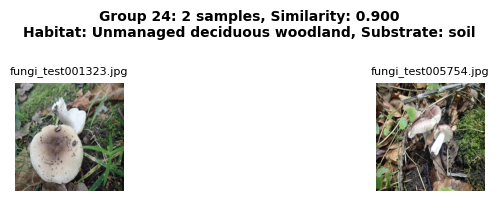


Group 25:
  Visual Similarity: 0.900
  Sample Count: 2
  Habitat: Thorny scrubland
  Substrate: soil
  Location: Lat_56.217_Lon_10.569
  Date: 2017-07
  Files: fungi_test003584.jpg, fungi_test004998.jpg...


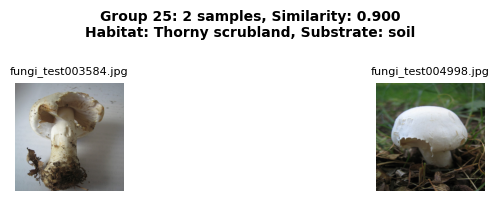

In [10]:
# Performance settings - adjust these to control compute load
VISUALIZE_GROUPS = True  # Set to False to skip visualization
MAX_GROUPS_TO_SHOW = 25   # Reduced from 30 to 5 for better performance
MAX_IMAGES_PER_GROUP = 4  # Reduced from 6 to 4

if VISUALIZE_GROUPS and len(sorted_groups) > 0:
    print(f"Visualizing top {MAX_GROUPS_TO_SHOW} agreement groups (lowest visual similarity)...")
    print("=" * 60)
    
    # Limit the number of groups to visualize
    groups_to_show = min(MAX_GROUPS_TO_SHOW, len(sorted_groups))
    
    for i, (signature, group_info) in enumerate(sorted_groups[-groups_to_show:], 1):
        print(f"\nGroup {i}:")
        print(f"  Visual Similarity: {group_info['avg_visual_similarity']:.3f}")
        print(f"  Sample Count: {group_info['count']}")
        print(f"  Habitat: {group_info['habitat']}")
        print(f"  Substrate: {group_info['substrate']}")
        print(f"  Location: {group_info['location']}")
        print(f"  Date: {group_info['date']}")
        print(f"  Files: {', '.join(group_info['filenames'][:3])}...")
        
        visualize_agreement_group(group_info, i, max_images=MAX_IMAGES_PER_GROUP)
        
else:
    print("Visualization skipped (VISUALIZE_GROUPS=False) or no groups found.")

Visualizing top 5 agreement groups (highest visual similarity)...

Group 1:
  Visual Similarity: 1.000
  Sample Count: 2
  Habitat: coniferous woodland/plantation
  Substrate: leaf or needle litter
  Location: Lat_56.164_Lon_9.627
  Date: 2010-10
  Files: fungi_final000596.jpg, fungi_final002231.jpg...


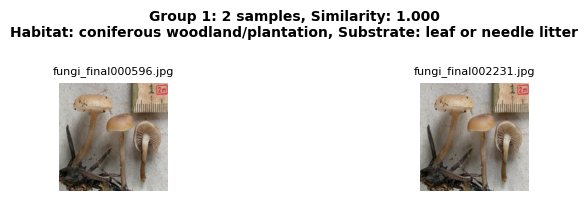


Group 2:
  Visual Similarity: 1.000
  Sample Count: 2
  Habitat: Deciduous woodland
  Substrate: dead wood (including bark)
  Location: Lat_55.784_Lon_12.579
  Date: 2016-10
  Files: fungi_final001916.jpg, fungi_test001341.jpg...


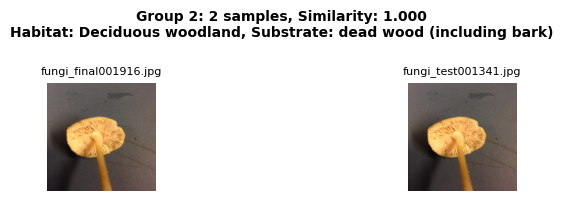


Group 3:
  Visual Similarity: 1.000
  Sample Count: 2
  Habitat: roadside
  Substrate: soil
  Location: Lat_56.396_Lon_9.891
  Date: 2010-06
  Files: fungi_final001292.jpg, fungi_final003089.jpg...


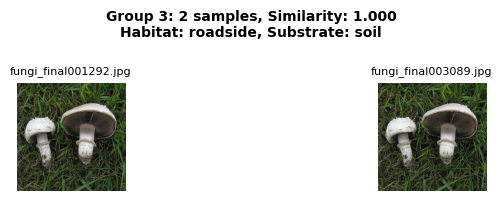


Group 4:
  Visual Similarity: 1.000
  Sample Count: 2
  Habitat: coniferous woodland/plantation
  Substrate: soil
  Location: Lat_55.406_Lon_8.412
  Date: 2020-07
  Files: fungi_test001632.jpg, fungi_test003762.jpg...


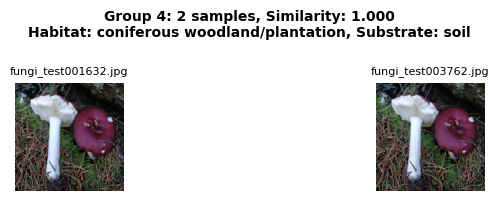


Group 5:
  Visual Similarity: 1.000
  Sample Count: 2
  Habitat: Mixed woodland (with coniferous and deciduous trees)
  Substrate: soil
  Location: Lat_55.893_Lon_10.056
  Date: 2010-09
  Files: fungi_final001510.jpg, fungi_test000702.jpg...


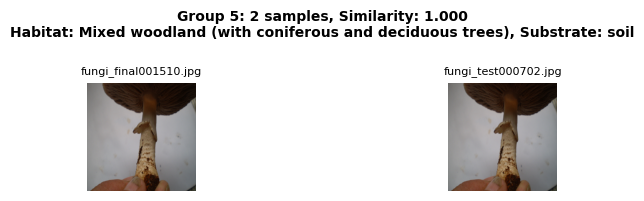

In [8]:
if VISUALIZE_GROUPS and len(sorted_groups) > 0:
    print(f"Visualizing top {MAX_GROUPS_TO_SHOW} agreement groups (highest visual similarity)...")
    print("=" * 60)
    
    # Limit the number of groups to visualize
    groups_to_show = min(MAX_GROUPS_TO_SHOW, len(sorted_groups))
    
    for i, (signature, group_info) in enumerate(sorted_groups[:groups_to_show], 1):
        print(f"\nGroup {i}:")
        print(f"  Visual Similarity: {group_info['avg_visual_similarity']:.3f}")
        print(f"  Sample Count: {group_info['count']}")
        print(f"  Habitat: {group_info['habitat']}")
        print(f"  Substrate: {group_info['substrate']}")
        print(f"  Location: {group_info['location']}")
        print(f"  Date: {group_info['date']}")
        print(f"  Files: {', '.join(group_info['filenames'][:3])}...")
        
        visualize_agreement_group(group_info, i, max_images=MAX_IMAGES_PER_GROUP)
        
        # Add a small delay to prevent overwhelming the system
        import time
        time.sleep(0.1)
else:
    print("Visualization skipped (VISUALIZE_GROUPS=False) or no groups found.")

In [9]:
# Summary of Results
print("\n" + "=" * 80)
print("SUMMARY: Metadata + CLIP Visual Agreement Groups")
print("=" * 80)

print(f"\n✅ FOUND GROUPS WITH BOTH CONDITIONS:")
print(f"   • Metadata Agreement (hard): Identical ecological context")
print(f"   • Visual Agreement (≥{visual_threshold}): High CLIP similarity")

print(f"\n📊 RESULTS:")
print(f"   • Total agreement groups: {len(agreement_groups)}")
print(f"   • Total samples in groups: {sum(g['count'] for g in agreement_groups.values())}")
print(f"   • Largest group: {max(group_sizes)} samples")
print(f"   • Average visual similarity: {np.mean(similarities):.3f}")

print(f"\n🎯 INTERPRETATION:")
print(f"   These groups represent fungi samples that are:")
print(f"   1. Collected from identical ecological contexts (same metadata)")
print(f"   2. Visually similar according to CLIP features")
print(f"   → Strong candidates for multimodal fungi classification!")

# Save results
results_df = pd.DataFrame([
    {
        'group_id': i,
        'metadata_signature': sig,
        'sample_count': info['count'],
        'avg_visual_similarity': info['avg_visual_similarity'],
        'habitat': info['habitat'],
        'substrate': info['substrate'],
        'location': info['location'],
        'date': info['date'],
        'filenames': ';'.join(info['filenames'])
    }
    for i, (sig, info) in enumerate(sorted_groups, 1)
])

output_path = '/work3/monka/SummerSchool2025/metadata_clip_agreement_groups.csv'
results_df.to_csv(output_path, index=False)
print(f"\n💾 Results saved to: {output_path}")
print(f"✨ Analysis complete!")


SUMMARY: Metadata + CLIP Visual Agreement Groups

✅ FOUND GROUPS WITH BOTH CONDITIONS:
   • Metadata Agreement (hard): Identical ecological context
   • Visual Agreement (≥0.9): High CLIP similarity

📊 RESULTS:
   • Total agreement groups: 671
   • Total samples in groups: 1458
   • Largest group: 6 samples
   • Average visual similarity: 0.929

🎯 INTERPRETATION:
   These groups represent fungi samples that are:
   1. Collected from identical ecological contexts (same metadata)
   2. Visually similar according to CLIP features
   → Strong candidates for multimodal fungi classification!

💾 Results saved to: /work3/monka/SummerSchool2025/metadata_clip_agreement_groups.csv
✨ Analysis complete!
